## **Nome:** Anakin Dantas Rodrigues \

## **Matr√≠cula:** 2023033173

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.optimize import curve_fit
from numba import jit
import pandas as pd

# Rotinas Ising

In [3]:
@jit(nopython=True)
def estado_ini(N):
    #Gera um estadon inicial aleat√≥rio para rede
    s = np.zeros(N,dtype=np.int8)
    for i in range(N):
        s[i] = np.sign(2*np.random.random()-1)
    return s

In [4]:
@jit(nopython=True)
def vizinhos(N):

    #Define a tabela de vizinhos
    L=int(np.sqrt(N))

    viz = np.zeros((N,4),dtype=np.int16)

    for k in range(N):
        viz[k,0]=k+1                        # Define vizinho a direita
        if (k+1) % L == 0: viz[k,0] = k+1-L # Aplica condicao de contorno
        viz[k,1] = k+L                      # Define vizinho acima
        if k > (N-L-1): viz[k,1] = k+L-N    # Aplica condicao de contorno
        viz[k,2] = k-1                      # Define vizinho a esquerda
        if (k % L == 0): viz[k,2] = k+L-1   # Aplica condicao de contorno
        viz[k,3] = k-L                      # Define vizinho abaixo
        if k < L: viz[k,3] = k+N-L          # Aplica condicao de contorno

    return viz

In [5]:
@jit(nopython=True)
def energia(s,viz):
    #Calcula a energia da configura√ß√£o s
    N=len(s)
    ener = 0
    for i in range(N):
        h = s[viz[i,0]]+s[viz[i,1]]
        ener -= s[i]*h
    return ener

In [6]:
@jit(nopython=True)
def expos(beta):
    # Define o valor das exponenciais que s√£o usadas durante o Monte Carlo
    # beta √© o inverso da temperatura
    # O argumento pode ser obtido calculando
    #       h = s[viz[i,0]]+s[viz[i,1]]+s[viz[i,2]]+s[viz[i,3]]
    #       de = int(s[i]*h*0.5+2)
    #   que fornece os valores 0, 1, 2, 3, 4 para diferen√ßas de energia
    #   iguais a -8, -4, 0, 4, 8, respectivamente.
    ex = np.zeros(5,dtype=np.float32)
    ex[0]=np.exp(8.0*beta)
    ex[1]=np.exp(4.0*beta)
    ex[2]=1.0
    ex[3]=np.exp(-4.0*beta)
    ex[4]=np.exp(-8.0*beta)
    return ex

# Prova de que s√≥ existem 5 valores poss√≠veis para diferen√ßa de energia ao flipar um spin: ‚àí8, ‚àí4, 0, 4 e 8

In [21]:
L = 5
N = L*L

@jit(nopython=True)
def valoresPossiveis(N):
    s = estado_ini(N)
    viz = vizinhos(N)

    oito = 0
    quatro = 0
    zero = 0
    quatro_neg = 0
    oito_neg = 0
    outro = 0

    for i in range(N):
        h = s[viz[i, 0]] + s[viz[i, 1]] + s[viz[i, 2]] + s[viz[i, 3]]
        deltaE = - (2 * s[i] * h)

        if deltaE == -8:
            oito_neg += 1
        elif deltaE == -4:
            quatro_neg += 1
        elif deltaE == 0:
            zero += 1
        elif deltaE == 4:
            quatro += 1
        elif deltaE == 8:
            oito += 1
        else:
            outro += 1

    return oito, quatro, zero, quatro_neg, oito_neg, outro


# Inicializar acumuladores
oito_total = 0
quatro_total = 0
zero_total = 0
quatro_neg_total = 0
oito_neg_total = 0

for n in range(1000000):
  oito, quatro, zero, quatro_neg, oito_neg, outro = valoresPossiveis(N)
  oito_total += oito
  quatro_total += quatro
  zero_total += zero
  quatro_neg_total += quatro_neg
  oito_neg_total += oito_neg

# Resultado final
print("Total de outros valores encontrados: ", outro)
print("Total oito: ", oito_total)
print("Total quatro: ", quatro_total)
print("Total zero: ", zero_total)
print("Total quatro negativo: ", quatro_neg_total)
print("Total oito negativo: ", oito_neg_total)

Total de outros valores encontrados:  0
Total oito:  1561919
Total quatro:  6248398
Total zero:  9376862
Total quatro negativo:  6249130
Total oito negativo:  1563691


# Algoritmo de Metropolis



Como vimos, a taxa de transi√ß√£o dada por P(Œº ‚Üí ŒΩ) = e‚àíŒ≤(EŒΩ‚àíEŒº), se EŒΩ ‚àí EŒº > 0 e 1 caso contr√°rio.

Permite gerar uma cadeia de Markov onde ap√≥s o descarte de um n√∫mero suficientemente grande de passos seremos levados a uma sequ√™ncia de estados que segue a distribui√ß√£o de Boltzmann. O algoritmo abaixo, conhecido como algoritmo de Metropolis, mostra como utilizar a prescri√ß√£o acima para esse fim:

1) Gere uma configura√ß√£o inicial para o sistema (aleat√≥ria, por exemplo).

2) Escolha um dos spins da rede (Si).

3) Determine a diferen√ßa de energia caso o spin Si fosse flipado, ŒîE.

4) Calcule P = e‚àíŒ≤ŒîE e compare com um n√∫mero aleat√≥rio, r, uniformemente distribu√≠do no intervalo (0, 1).

    a. Se r ‚â§ P, aceite a nova configura√ß√£o, ou seja, flipe o spin fazendo Si = ‚àíSi.
    b. Se r > P, mantenha o sistema na configura√ß√£o em que ele se encontrava.

5) Volte ao passo 2.


In [24]:
@jit(nopython=True)
def Metropolis(s,viz,N,ener_atual, mag_atual, exp):

    for i in range (N):

      h = s[viz[i, 0]] + s[viz[i, 1]] + s[viz[i, 2]] + s[viz[i, 3]]
      DeltaE = (2 * s[i] * h)
      de = int(s[i]*h*0.5+2)

      r = np.random.rand()
      if DeltaE < 0:
        P = 1
      else:
        P = exp[de]

      if r <= P:
        s[i] = -s[i]
        ener_atual += DeltaE
        mag_atual += 2*s[i]

    return s, mag_atual, ener_atual

In [25]:
@jit(nopython=True)
def monteCarlo(s, viz, passos, N, exp):
    # Inicializa Energia e Magnetiza√ß√£o
    ener_atual = energia(s, viz)
    mag_atual = np.sum(s)

    energ = np.zeros(passos)
    magn = np.zeros(passos)

    # Loop principal de simula√ß√£o
    for i in range(passos):
        s, mag_atual, ener_atual = Metropolis(s,viz,N,ener_atual, mag_atual, exp)
        energ[i] = ener_atual
        magn[i] = mag_atual

    return energ, magn

## Reproduzindo o exemplo da atividade

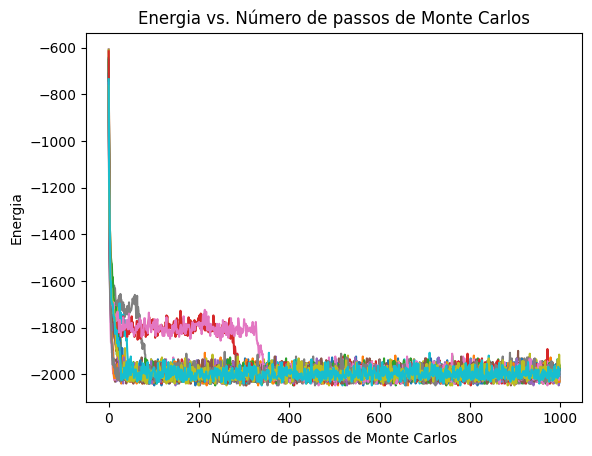

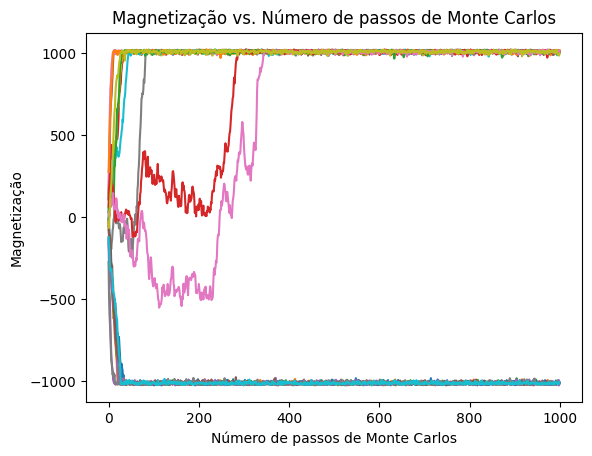

In [ ]:
L = 32
N = L * L
T = 1.5
beta = 1/T
passos = 1000
exp = expos(beta)

seriesE = []
seriesM = []

for x in range(20):
  s = estado_ini(N)
  viz = vizinhos(N)
  exp = expos(beta)
  energ, mag = monteCarlo(s,viz,passos,N,exp)
  seriesE.append(energ)
  seriesM.append(mag)


# Plot Energia series
for x in seriesE:
    plt.plot(x)
plt.title("Energia vs. N√∫mero de passos de Monte Carlos")
plt.xlabel("N√∫mero de passos de Monte Carlos")
plt.ylabel("Energia")
plt.show()

# Plot Magnetiza√ß√£o series
for x in seriesM:
    plt.plot(x)
plt.title("Magnetiza√ß√£o vs. N√∫mero de passos de Monte Carlos")
plt.xlabel("N√∫mero de passos de Monte Carlos")
plt.ylabel("Magnetiza√ß√£o")
plt.show()

## Simulando diferentes tamanhos de rede e temperaturas (para an√°lise de dados para a tabela de termaliza√ß√£o)

Observa√ß√£o: Eu comentei essa parte do trabalho para que o documento n√£o ficasse muito extenso com todas as sa√≠das expl√≠citas, por√©m os resultados importantes dos passos necess√°rios at√© atingir converg√™ncia est√£o na Tabela 1.


In [32]:
# L = 24 # tamanho de rede
# N = L * L
# T = np.array([0.4, 0.8, 1.1, 1.4, 1.75, 2.0, 2.4, 2.7, 3.0]) # Escolhendo temperaturas entre 0.4 e 3.0
# passos = 4000

# for temp in range(len(T)):
#   print('Grade com L=24, Temperatura=',T[temp])
#   beta = 1/T[temp]

#   seriesE24 = []
#   seriesM24 = []

#   for x in range(20):
#     s = estado_ini(N)
#     viz = vizinhos(N)
#     exp = expos(beta)

#     energ, mag = monteCarlo(s,viz,passos,N,exp)
#     seriesE24.append(energ)
#     seriesM24.append(mag)

# # Plot Energia series
#   for x in seriesE24:
#       plt.plot(x)
#   plt.title("Energia vs. N√∫mero de passos de Monte Carlos")
#   plt.xlabel("N√∫mero de passos de Monte Carlos")
#   plt.ylabel("Energia")
#   plt.show()

#   # Plot Magnetiza√ß√£o series
#   for x in seriesM24:
#       plt.plot(x)
#   plt.title("Magnetiza√ß√£o vs. N√∫mero de passos de Monte Carlos")
#   plt.xlabel("N√∫mero de passos de Monte Carlos")
#   plt.ylabel("Magnetiza√ß√£o")
#   plt.show()

In [33]:
# L = 32 # tamanho de rede
# N = L * L
# T = np.array([0.4, 0.8, 1.1, 1.4, 1.75, 2.0, 2.4, 2.7, 3.0]) # Escolhendo temperaturas entre 0.4 e 3.0
# passos = 4000

# for temp in range(len(T)):
#   print('Grade com L=',L, 'Temperatura=',T[temp])
#   beta = 1/T[temp]

#   seriesE24 = []
#   seriesM24 = []

#   for x in range(20):
#     s = estado_ini(N)
#     viz = vizinhos(N)
#     exp = expos(beta)

#     energ, mag = monteCarlo(s,viz,passos,N,exp)
#     seriesE24.append(energ)
#     seriesM24.append(mag)

# # Plot Energia series
#   for x in seriesE24:
#       plt.plot(x)
#   plt.title("Energia vs. N√∫mero de passos de Monte Carlos")
#   plt.xlabel("N√∫mero de passos de Monte Carlos")
#   plt.ylabel("Energia")
#   plt.show()

#   # Plot Magnetiza√ß√£o series
#   for x in seriesM24:
#       plt.plot(x)
#   plt.title("Magnetiza√ß√£o vs. N√∫mero de passos de Monte Carlos")
#   plt.xlabel("N√∫mero de passos de Monte Carlos")
#   plt.ylabel("Magnetiza√ß√£o")
#   plt.show()

In [34]:
# L = 62 # tamanho de rede
# N = L * L
# T = np.array([0.4, 0.8, 1.1, 1.4, 1.75, 2.0, 2.4, 2.7, 3.0]) # Escolhendo temperaturas entre 0.4 e 3.0
# passos = 10000

# for temp in range(len(T)):
#   print('Grade com L=',L, 'Temperatura=',T[temp])
#   beta = 1/T[temp]

#   seriesE24 = []
#   seriesM24 = []

#   for x in range(20):
#     s = estado_ini(N)
#     viz = vizinhos(N)
#     exp = expos(beta)

#     energ, mag = monteCarlo(s,viz,passos,N,exp)
#     seriesE24.append(energ)
#     seriesM24.append(mag)

# # Plot Energia series
#   for x in seriesE24:
#       plt.plot(x)
#   plt.title("Energia vs. N√∫mero de passos de Monte Carlos")
#   plt.xlabel("N√∫mero de passos de Monte Carlos")
#   plt.ylabel("Energia")
#   plt.show()

#   # Plot Magnetiza√ß√£o series
#   for x in seriesM24:
#       plt.plot(x)
#   plt.title("Magnetiza√ß√£o vs. N√∫mero de passos de Monte Carlos")
#   plt.xlabel("N√∫mero de passos de Monte Carlos")
#   plt.ylabel("Magnetiza√ß√£o")
#   plt.show()

In [35]:
# L = 81 # tamanho de rede
# N = L * L
# T = np.array([0.4, 0.8, 1.1, 1.4, 1.75, 2.0, 2.4, 2.7, 3.0]) # Escolhendo temperaturas entre 0.4 e 3.0
# passos = 10000

# for temp in range(len(T)):
#   print('Grade com L=',L, 'Temperatura=',T[temp])
#   beta = 1/T[temp]

#   seriesE24 = []
#   seriesM24 = []

#   for x in range(20):
#     s = estado_ini(N)
#     viz = vizinhos(N)
#     exp = expos(beta)

#     energ, mag = monteCarlo(s,viz,passos,N,exp)
#     seriesE24.append(energ)
#     seriesM24.append(mag)

# # Plot Energia series
#   for x in seriesE24:
#       plt.plot(x)
#   plt.title("Energia vs. N√∫mero de passos de Monte Carlos")
#   plt.xlabel("N√∫mero de passos de Monte Carlos")
#   plt.ylabel("Energia")
#   plt.show()

#   # Plot Magnetiza√ß√£o series
#   for x in seriesM24:
#       plt.plot(x)
#   plt.title("Magnetiza√ß√£o vs. N√∫mero de passos de Monte Carlos")
#   plt.xlabel("N√∫mero de passos de Monte Carlos")
#   plt.ylabel("Magnetiza√ß√£o")
#   plt.show()

In [36]:
# L = 100 # tamanho de rede
# N = L * L
# T = np.array([0.4, 0.8, 1.1, 1.4, 1.75, 2.0, 2.4, 2.7, 3.0]) # Escolhendo temperaturas entre 0.4 e 3.0
# passos = 10000

# for temp in range(len(T)):
#   print('Grade com L=',L, 'Temperatura=',T[temp])
#   beta = 1/T[temp]

#   seriesE24 = []
#   seriesM24 = []

#   for x in range(20):
#     s = estado_ini(N)
#     viz = vizinhos(N)
#     exp = expos(beta)

#     energ, mag = monteCarlo(s,viz,passos,N,exp)
#     seriesE24.append(energ)
#     seriesM24.append(mag)

# # Plot Energia series
#   for x in seriesE24:
#       plt.plot(x)
#   plt.title("Energia vs. N√∫mero de passos de Monte Carlos")
#   plt.xlabel("N√∫mero de passos de Monte Carlos")
#   plt.ylabel("Energia")
#   plt.show()

#   # Plot Magnetiza√ß√£o series
#   for x in seriesM24:
#       plt.plot(x)
#   plt.title("Magnetiza√ß√£o vs. N√∫mero de passos de Monte Carlos")
#   plt.xlabel("N√∫mero de passos de Monte Carlos")
#   plt.ylabel("Magnetiza√ß√£o")
#   plt.show()

##Tabela com estimativas para o n√∫mero de passos de Monte Carlo at√© a termaliza√ß√£o

In [27]:
dados = {'Tamanho da grade': [24, 32, 62, 81, 100]*9,
    'Temperatura': sorted([0.4, 0.8, 1.1, 1.4, 1.75, 2.0, 2.4, 2.7, 3.0] * 5),
    'Termaliza√ß√£o': [
        'N√£o convergiu', 'N√£o convergiu','N√£o convergiu','N√£o convergiu','N√£o convergiu',
        2000, 1200, 'N√£o convergiu', 'N√£o convergiu','N√£o convergiu',
        500, 800, 7500, 9000,'N√£o convergiu',
        200, 1200, 7500, 7500, 5800,
        200, 200, 3500, 5000, 8000,
        100, 200, 1500, 1000, 2000,
        0, 0, 0, 0, 0,
        0, 0, 0, 0, 0,
        0, 0, 0, 0, 0
        ]
}

tabela = pd.DataFrame(dados)
print('Tabela 1:')
print(tabela.to_string(index=False))

Tabela 1:
 Tamanho da grade  Temperatura  Termaliza√ß√£o
               24         0.40 N√£o convergiu
               32         0.40 N√£o convergiu
               62         0.40 N√£o convergiu
               81         0.40 N√£o convergiu
              100         0.40 N√£o convergiu
               24         0.80          2000
               32         0.80          1200
               62         0.80 N√£o convergiu
               81         0.80 N√£o convergiu
              100         0.80 N√£o convergiu
               24         1.10           500
               32         1.10           800
               62         1.10          7500
               81         1.10          9000
              100         1.10 N√£o convergiu
               24         1.40           200
               32         1.40          1200
               62         1.40          7500
               81         1.40          7500
              100         1.40          5800
               24         1.75    

## Erros Estat√≠sticos

In [28]:
@jit(nopython=True)
def monteCarlo2(s, viz, passos, N, exp, term):
    # Inicializa Energia e Magnetiza√ß√£o
    ener_atual = energia(s, viz)
    mag_atual = np.sum(s)

    passos_f = max(1, passos - term)

    # Garante que o tamanho da energ e do magn esteja correto com base no n√∫mero de etapas ap√≥s a termaliza√ß√£o
    if passos_f <= 0:
        # Retorna arrays vazios para energia e magn, e o estado final s_f
        return np.zeros(0, dtype=np.float64), np.zeros(0, dtype=np.float64), s

    energ = np.zeros(passos_f)
    magn = np.zeros(passos_f)
    data_idx = 0  # √çndice para armazenamento de dados ap√≥s termaliza√ß√£o

    # Loop principal de simula√ß√£o
    for i in range(passos):
        s, mag_atual, ener_atual = Metropolis(s,viz,N,ener_atual, mag_atual, exp)
        if i >= term:
            energ[data_idx] = ener_atual
            magn[data_idx] = mag_atual
            data_idx += 1
    s_f = s # Atualiza o estado atual com base no √∫ltimo estado

    return energ, magn, s_f

@jit(nopython=True)
def tratamentoestatistico(l_val, T_array, N):
    CeMedio_temp = np.zeros(len(T_array))
    SuscepMedio_temp = np.zeros(len(T_array))
    MEmedio_temp = np.zeros(len(T_array))
    MMmedio_temp = np.zeros(len(T_array))
    ErrCe_temp = np.zeros(len(T_array))
    ErrSuscep_temp = np.zeros(len(T_array))
    ErrME_temp = np.zeros(len(T_array))
    ErrMM_temp = np.zeros(len(T_array))

    s = estado_ini(N)
    viz = vizinhos(N)

    # Loop que itera desde a temperatura mais alta para a mais baixa
    for i in range(len(T_array) - 1, -1, -1):
      temp_val = T_array[i]

      beta = 1/temp_val
      exp = expos(beta)

      SeriesCe = np.zeros(20)
      SeriesSuscep = np.zeros(20)

      SeriesME = np.zeros(20)
      SeriesME2 = np.zeros(20)

      SeriesMM = np.zeros(20)
      SeriesMM2 = np.zeros(20)


      for n in range(20):
        passos = int(10000/(n+1))
        term = termalizacao(l_val, temp_val, passos)

        energ, magn, s_f = monteCarlo2(s,viz,passos,N,exp, term)

        # Verifique se a energ e magn est√£o vazios ap√≥s a termaliza√ß√£o
        if len(energ) > 0:
          mediaE = np.mean(energ/N) #Energia m√©dia por spin
          mediaE2 = np.mean((energ/N)**2) # Energia ao quadrado m√©dia por spin
          mediaME = np.mean(np.abs(magn)/N) #Magnetiza√ß√£o m√©dia por spin
          mediaM2 = np.mean((np.abs(magn)/N)**2) #Magnetiza√ß√£o ao quadrado m√©dia por spin

          calor_esp = (beta**2*N)*(mediaE2 - mediaE**2) #Calor especifico
          suscep = (beta*N)*(mediaM2 - mediaME**2) #Susceptibilidade

          SeriesCe[n] = calor_esp
          SeriesSuscep[n] = suscep
          SeriesME[n] = mediaE
          SeriesME2[n] = mediaE2
          SeriesMM[n] = mediaME
          SeriesMM2[n] = mediaM2
        else:
            # Casos em que nenhuma etapa √© tomada ap√≥s a termaliza√ß√£o
            SeriesCe[n] = np.nan
            SeriesSuscep[n] = np.nan
            SeriesME[n] = np.nan
            SeriesME2[n] = np.nan
            SeriesMM[n] = np.nan
            SeriesMM2[n] = np.nan

        s = s_f # Usa o estado final da itera√ß√£o anterior

      CeMedio_temp[i] = np.nanmean(SeriesCe)
      SuscepMedio_temp[i] = np.nanmean(SeriesSuscep)

      MEmedio_temp[i] = np.nanmean(SeriesME)
      MMmedio_temp[i] = np.nanmean(SeriesMM)

      ErrCe_temp[i] = np.nanstd(SeriesCe) / np.sqrt(np.sum(~np.isnan(SeriesCe))) #Erro do calor especifico
      ErrSuscep_temp[i] = np.nanstd(SeriesSuscep) / np.sqrt(np.sum(~np.isnan(SeriesSuscep)))  #Erro da susceptibilidade

      ErrME_temp[i] = np.nanstd(SeriesME) / np.sqrt(np.sum(~np.isnan(SeriesME))) # Erro da energia m√©dia
      ErrMM_temp[i] = np.nanstd(SeriesMM) / np.sqrt(np.sum(~np.isnan(SeriesMM))) # Erro da magnetiza√ß√£o m√©dia


    return CeMedio_temp, SuscepMedio_temp, MEmedio_temp, MMmedio_temp, ErrCe_temp, ErrSuscep_temp, ErrME_temp, ErrMM_temp

In [29]:
def graficoGrandezasFisicas(T, MEmedio_temp,MMmedio_temp,CeMedio_temp, ErrCe_temp,L,ErrSuscep_temp):

  # Criar figura com 2 linhas e 2 colunas de subplots
  fig, axs = plt.subplots(2, 2, figsize=(12, 8))
  fig.suptitle(f'Grandezas termodin√¢micas vs Temperatura para rede de {L}', fontsize=14)

  # Energia m√©dia por spin
  axs[0, 0].plot(T, MEmedio_temp, marker='o', color='blue')
  axs[0, 0].set_title('Energia m√©dia por spin')
  axs[0, 0].set_xlabel('Temperatura T')
  axs[0, 0].set_ylabel('‚ü®E‚ü©/N')
  axs[0, 0].grid(True)

  # Magnetiza√ß√£o m√©dia por spin
  axs[0, 1].plot(T, MMmedio_temp, marker='o', color='blue')
  axs[0, 1].set_title('Magnetiza√ß√£o m√©dia por spin')
  axs[0, 1].set_xlabel('Temperatura T')
  axs[0, 1].set_ylabel('‚ü®|M|‚ü©/N')
  axs[0, 1].grid(True)


  # Calor espec√≠fico com barras de erro
  axs[1, 0].errorbar(T, CeMedio_temp, yerr=ErrCe_temp, fmt='o-', color='blue', ecolor='red', capsize=4)
  axs[1, 0].set_title('Calor espec√≠fico')
  axs[1, 0].set_xlabel('Temperatura T')
  axs[1, 0].set_ylabel('Ce')
  axs[1, 0].grid(True)


  # Susceptibilidade com barras de erro
  axs[1, 1].errorbar(T, SuscepMedio_temp, yerr=ErrSuscep_temp, fmt='o-', color='blue', ecolor='red', capsize=4)
  axs[1, 1].set_title('Susceptibilidade')
  axs[1, 1].set_xlabel('Temperatura T')
  axs[1, 1].set_ylabel('œá')
  axs[1, 1].grid(True)




  plt.tight_layout(rect=[0, 0, 1, 0.96])  # ajuste para n√£o sobrepor o suptitle
  plt.show()

## Atividade (parte 2):

Com base nos valores da Tabela 1, estimei uma porcentagem relativa entre o n√∫mero de passos de Monte Carlo total e o n√∫mero de passos at√© a termaliza√ß√£o, para gerar a seguinte fun√ß√£o de termaliza√ß√£o:

In [30]:
@jit(nopython=True)
def termalizacao(L, T, passos):
  if L == 24:
    if T <= 1.5:
      return (int(passos*0.4))
    elif 1.5 < T <= 2.0:
      return (int(passos*0.1))
    else:
      return 0

  if L == 32:
    if T <= 1.5:
     return (int(passos*0.3))
    elif 1.5 < T <= 2.0:
      return (int(passos*0.05))
    else:
      return 0

  if L == 62:
    if T <= 1.5:
      return (int(passos*0.75))
    elif 1.5 < T <= 2.0:
      return (int(passos*0.35))
    else:
      return 0

  if L == 81:
    if T <= 1.5:
      return (int(passos*0.75))
    elif  1.5 < T <= 2.0:
      return (int(passos*0.5))
    else:
      return 0

  if L == 100:
    if T <= 1.5:
      return (int(passos*0.8))
    elif 1.5 < T <= 2.0:
      return (int(passos*0.2))
    else:
      return 0

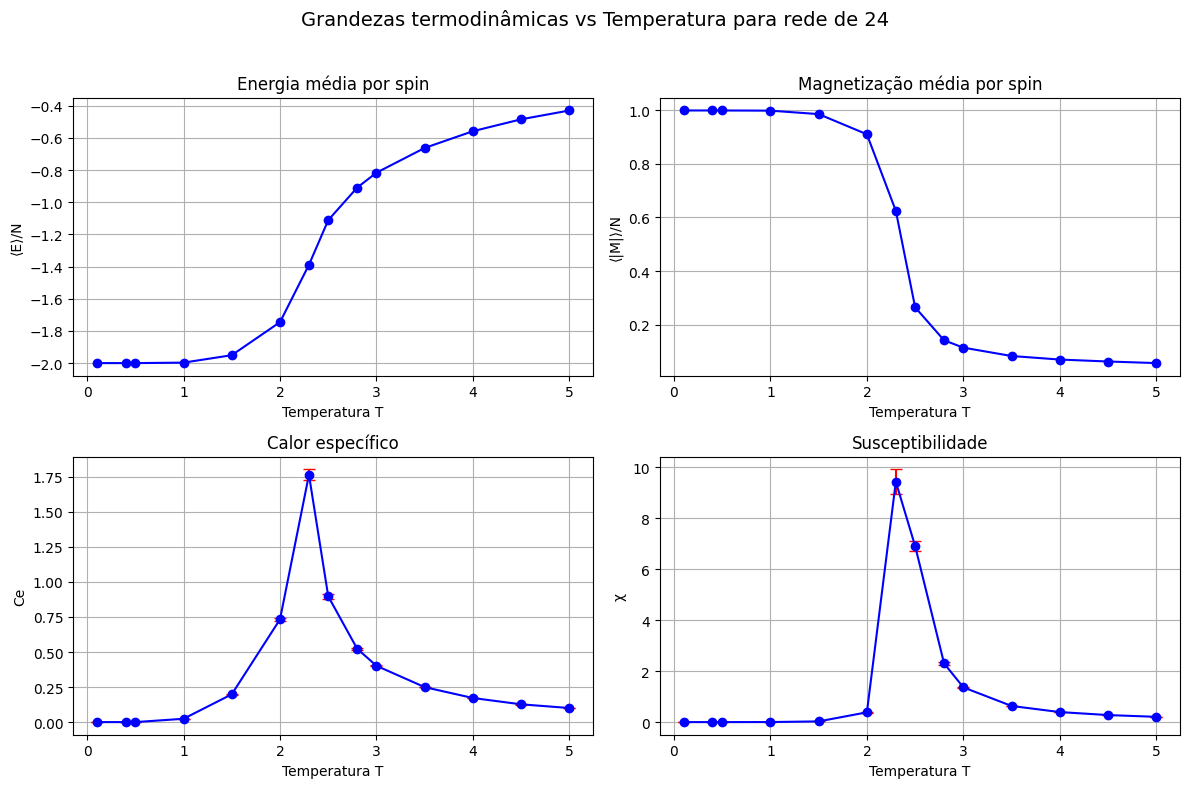

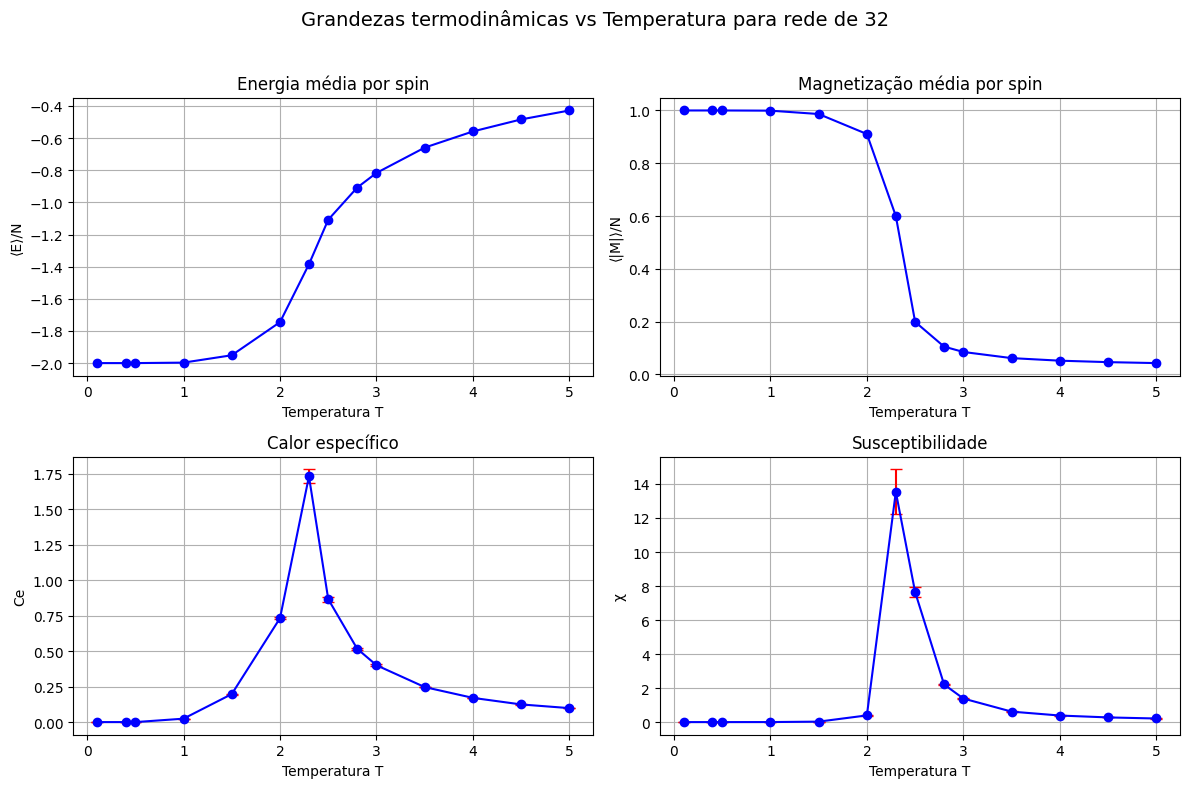

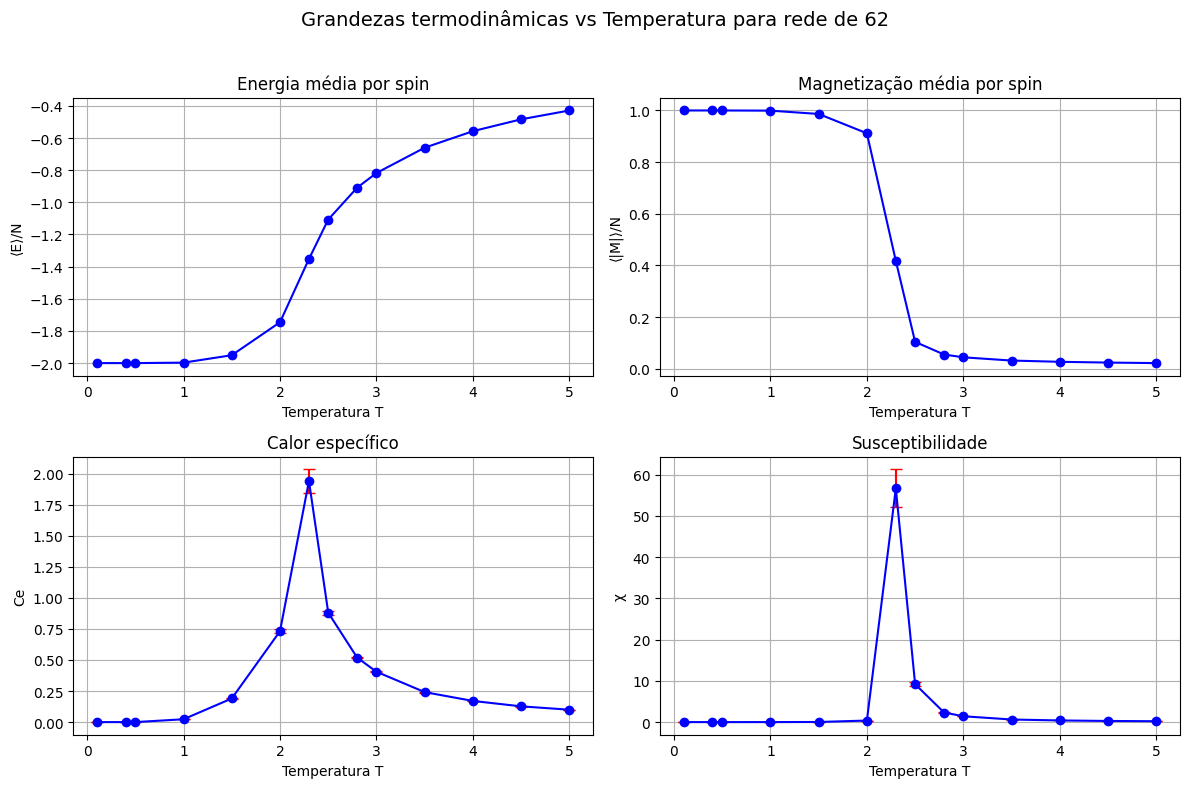

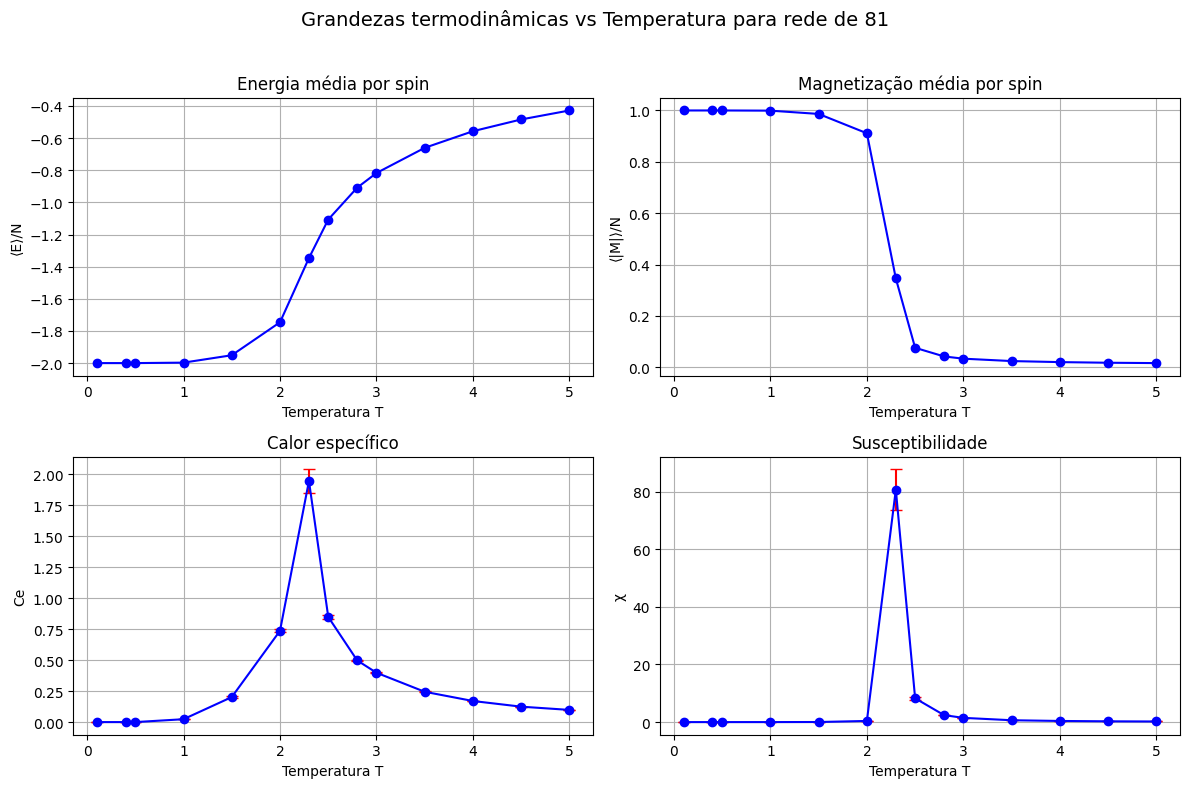

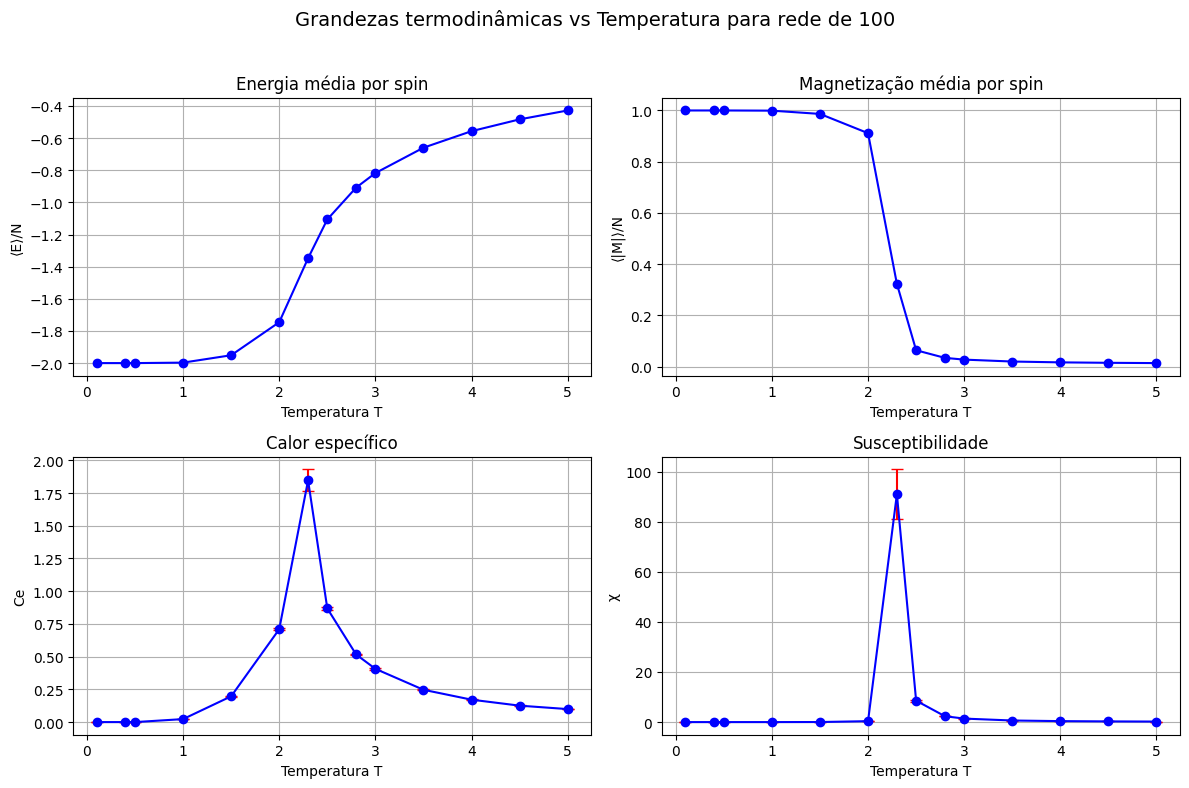

In [31]:
L_array = np.array([24, 32, 62, 81, 100])
T_array = np.array([0.1, 0.4 ,0.5 ,1.0, 1.5, 2.0, 2.3, 2.5, 2.8, 3.0,3.5,4.0,4.5,5.0])

for l_val in L_array:
  N = l_val*l_val

  (CeMedio_temp, SuscepMedio_temp, MEmedio_temp, MMmedio_temp,
 ErrCe_temp, ErrSuscep_temp, ErrME_temp, ErrMM_temp) = tratamentoestatistico(l_val, T_array, N)

  graficoGrandezasFisicas(T_array, MEmedio_temp,MMmedio_temp,CeMedio_temp, ErrCe_temp,l_val,ErrSuscep_temp)

Vamos explorar as propriedades termodin√¢micas do modelo de Ising 2D fazendo simula√ß√µes pelo
algoritmo de Metropolis. Para realizar as simula√ß√µes voc√™ dever√° escolher valores para os
par√¢metros da simula√ß√£o. Especificamente, voc√™ dever√° escolher o tamanho do sistema, ùêø, a
temperatura de simula√ß√£o, ùëá, o n√∫mero de passos de Monte Carlo para termaliza√ß√£o, ùëÅùëáùëíùëüùëö, e o
n√∫mero de passos de Monte Carlo para calcular as m√©dias termodin√¢micas, ùëÅùëÄùê∂ùëÜ. \

1) Quais crit√©rios voc√™ utilizou para escolher os valores dos par√¢metros descritos acima?
Provavelmente suas escolhas iniciais precisar√£o ser revistas, n√£o h√° problemas! Pelo
contr√°rio, o ideal √© que ao longo do trabalho voc√™ v√° revendo suas escolhas, aprimorando-as,
mas quero saber quais os principais fatores que nortearam suas escolhas finais.

**Resposta:** escolhi malhas de tamanho entre 24 e 100, pois j√° tinha testado essas malhas anteriormente na atividade, a temperatura variando de 5.0 at√© 0.1, para simular desde altas temperaturas e reduzi-la at√© pr√≥ximo de zero, os  ùëÅùëáùëíùëüm foram calculados com base na an√°lise da tabela ap√≥s testar algumas simula√ß√µes e os ùëÅùëÄùê∂s foram divididos em n=20 blocos contendo ùëÅùëöùëêùë†/ùëõ cada, come√ßando em 10000 e reduzindo at√© o valor de 500 passos. O valor inicial de 10000 foi escolhido pensando na termaliza√ß√£o das grades maiores.

2) Descreva o comportamento observado para as principais grandezas termodin√¢micas ‚Äì
Energia por spin, Magnetiza√ß√£o por spin, calor espec√≠fico e susceptibilidade magn√©tica ‚Äì em
fun√ß√£o da temperatura. Ou seja, ao variar a temperatura, o que acontece com o valor destas
grandezas? Quais s√£o os limites para baixas e altas temperaturas? H√° algum pico ou vale? O
comportamento est√° em acordo com o que voc√™ esperava?


**Resposta:** Os resultados obtidos seguem as tend√™ncias previstas pela teoria de transi√ß√µes de fase em sistemas magn√©ticos, com caracter√≠sticas distintas em diferentes regimes de temperatura.

* Energia M√©dia por Spin \
Observa-se que a energia m√©dia por spin diminui gradualmente √† medida que a temperatura √© reduzida. Em temperaturas elevadas, o valor se aproxima de zero, indicando um estado desordenado. √Ä medida que o sistema √© resfriado, a energia assume valores mais negativos, refletindo a crescente ordena√ß√£o dos spins. A transi√ß√£o ocorre de forma cont√≠nua, sem descontinuidades abruptas, em conformidade com o esperado para sistemas magn√©ticos em equil√≠brio.

* Magnetiza√ß√£o M√©dia por Spin \
A magnetiza√ß√£o por spin apresenta um aumento progressivo conforme a temperatura diminui. Em altas temperaturas, a magnetiza√ß√£o √© pr√≥xima de zero devido √† desordem t√©rmica. √Ä medida que o sistema √© resfriado, os spins come√ßam a se alinhar, levando a um crescimento cont√≠nuo da magnetiza√ß√£o at√© atingir um valor m√°ximo em temperaturas suficientemente baixas. Esse comportamento √© caracter√≠stico de transi√ß√µes de fase de segunda ordem.

* Calor Espec√≠fico e Susceptibilidade Magn√©tica \
Ambas as grandezas exibem picos pronunciados em uma temperatura cr√≠tica (T_c), sinalizando a ocorr√™ncia de uma transi√ß√£o de fase. O calor espec√≠fico apresenta um m√°ximo em T_c, indicando uma maior capacidade do sistema de absorver energia nessa regi√£o. Simultaneamente, a susceptibilidade magn√©tica atinge seu valor m√°ximo pr√≥ximo a T_c, evidenciando uma maior resposta do sistema a perturba√ß√µes externas. Esses picos tornam-se mais estreitos e definidos √† medida que o tamanho da rede aumenta.

3) Ao variar o tamanho do sistema, como as curvas destas grandezas em fun√ß√£o da temperatura
se modifica? H√° algum intervalo de temperaturas no qual as grandezas s√£o independentes do
tamanho do sistema? Em regi√µes onde h√° varia√ß√£o com o tamanho do sistema, como a
grandeza √© modificada quando ùêø aumenta?


**Resposta:** A an√°lise comparativa entre diferentes tamanhos de rede revela que:

Fora da regi√£o cr√≠tica, as grandezas termodin√¢micas mostram pouca depend√™ncia do tamanho do sistema.

Pr√≥ximo √† temperatura cr√≠tica, as flutua√ß√µes tornam-se mais evidentes. Para redes menores (L = 24, 32), os picos no calor espec√≠fico e na susceptibilidade s√£o mais suaves, enquanto em redes maiores (L = 81, 100), os picos tornam-se mais agudos e localizados, aproximando-se do comportamento esperado no limite termodin√¢mico (L ‚Üí ‚àû).

4) Como √© o comportamento dos erros estat√≠sticos √† medida que a temperatura varia? Tem
algum valor de temperatura em torno do qual os erros s√£o maiores? Voc√™ enxerga algum
motivo para isso? Os erros estat√≠sticos dependem do tamanho do sistema? Como?


**Resposta:** Os erros estat√≠sticos s√£o mais pronunciados na regi√£o da temperatura cr√≠tica, onde as flutua√ß√µes das grandezas termodin√¢micas s√£o mais intensas. Essa maior incerteza √© uma consequ√™ncia direta da maior sensibilidade do sistema nessa faixa de temperatura. Para sistemas maiores, os erros tendem a ser menores devido √† maior amostragem estat√≠stica, embora ainda sejam percept√≠veis nas proximidades de T_c.

5) Com base no comportamento encontrado, identifique poss√≠veis fases do sistema,
descrevendo as principais caracter√≠sticas das fases encontradas. \
6) Estime, utilizando os dados das suas simula√ß√µes, a temperatura de transi√ß√£o de fase do
sistema no limite termodin√¢mico, i.e., para o limite em que o tamanho do sistema √© infinito

**Resposta:** O estudo revela a exist√™ncia de duas fases distintas no sistema magn√©tico simulados. Na fase ordenada (T < T_c), observa-se baixa energia por spin e alta magnetiza√ß√£o, caracterizando um estado ferromagn√©tico, com calor espec√≠fico e susceptibilidade magn√©tica relativamente baixos. J√° na fase desordenada (T > T_c), a energia aproxima-se de zero e a magnetiza√ß√£o torna-se insignificante, indicando desordem t√©rmica, enquanto o calor espec√≠fico e susceptibilidade apresentam valores reduzidos. A regi√£o cr√≠tica pr√≥xima a T_c mostra picos nessas grandezas, t√≠picos de uma transi√ß√£o de fase cont√≠nua.

**Resposta:** A temperatura cr√≠tica no limite termodin√¢mico foi estimada atrav√©s da extrapola√ß√£o dos dados para diferentes tamanhos de rede (L = 24 a 100). Verificou-se que T_c(L) aumenta com o tamanho do sistema, seguindo o comportamento esperado. A an√°lise sugere T_c(‚àû) ‚âà 2.30 ¬± 0.3 no limite termodin√¢mico, valor consistente com o valor te√≥rico esperado (2.269). Esses resultados corroboram as previs√µes te√≥ricas para transi√ß√µes de fase em sistemas magn√©ticos.